In [201]:
import itertools
from typing import Sequence
from functools import partial
from collections import defaultdict

import sympy
import numpy as np
from scipy.optimize import minimize

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style='whitegrid')
sns.set_palette('Set1')

# Contents

### 1. Gradient Projection
### 2. Newton: Newton: backtracking search
### 3. Simplex Method
### 4. Ellipsoid Method

# 1. Gradient Projection

$$
\begin{align*}
    \begin{cases}
        J(u) = ||u||^2 + \langle u, a \rangle^2 + \langle u, b \rangle \to inf, \mathbf{U} = \{u \in H \text{ }|\text{ }||u|| \le 2; \langle a, u \rangle \geq 1 \}\\
        ||a|| = 1 \\ ||b|| = 2 \\ \langle a, b \rangle = 0
    \end{cases}\,
\end{align*} \\ 

\alpha_k = const \\
u_0 = a
$$

$$
J'(u) = 2u + 2a\langle u, a \rangle + b \\
$$

In [207]:
a = np.random.rand(100)
a = a / np.linalg.norm(a)

b = np.random.rand(100)
b = b / np.linalg.norm(b)

b = b - a * np.dot(b, a)
b = b / np.linalg.norm(b) * 2

alpha = 1 / 4
u0 = a

assert np.allclose(np.linalg.norm(a), 1)
assert np.allclose(np.linalg.norm(b), 2)
assert np.allclose(np.dot(a, b), 0)

In [208]:
def compute_gradient(u : np.ndarray):
    return 2*u + 2*np.dot(u, a)*a + b

def projection(u : np.ndarray):
    A = np.stack((a, b/2), axis=1)
    projs = (A.T @ u[:, None]).ravel()

    if np.linalg.norm(u) <= 2:
        if np.dot(a, u) >= 1:
            return u
        u = a + projs[1] * b / 2
        if np.linalg.norm(u) <= 2:
            return u
        
        # return one of the corner points
        if projs[1] > 0:
           return a + np.sqrt(3)/2 * b
        return a - np.sqrt(3)/2 * b
    
    if np.dot(a, u) < 1:
        if np.abs(projs[1]) <= np.sqrt(3):
            return a + projs[1] * b / 2

        # return one of the corner points
        if projs[1] > 0:
           return a + np.sqrt(3)/2 * b
        return a - np.sqrt(3)/2 * b
    
    cos_a = np.dot(a, u) / np.linalg.norm(u)
    cos_bound = np.dot(a, a + np.sqrt(3)/2 * b) / 2

    if cos_a < cos_bound:
        # return one of the corner points
        if projs[1] > 0:
           return a + np.sqrt(3)/2 * b
        return a - np.sqrt(3)/2 * b
    
    return u / np.linalg.norm(u) * 2

def gradient_projection(alpha):
    k = 0
    uk = u0
    while True:
        k += 1
        u_proj = projection(uk - alpha * compute_gradient(uk))
        if np.allclose(u_proj, uk, rtol=1e-8):
            print(f'Num iterations {k}')
            return u_proj
        uk = u_proj

In [209]:
np.allclose(gradient_projection(alpha), a - b/2)

Num iterations 25


True

# 2. Newton: backtracking search 

$$
\begin{align*}
    \begin{cases}
        J(u) = ||u||^2 + \langle u, a \rangle^2 + \langle u, b \rangle \to inf, \mathbf{U} = \{u \in H \text{ }|\text{ }||u|| \le 2; \langle a, u \rangle \geq 1 \}\\
        ||a|| = 1 \\ ||b|| = 2 \\ \langle a, b \rangle = 0
    \end{cases}\,
\end{align*} \\ 

u_0 = a
$$

$$
J'(u) = 2u + 2a\langle u, a \rangle + b \\
J''(u)h = 2h + 2a\langle a, h \rangle
$$

In [204]:
a = np.random.rand(100)
a = a / np.linalg.norm(a)

b = np.random.rand(100)
b = b / np.linalg.norm(b)

b = b - a * np.dot(b, a)
b = b / np.linalg.norm(b) * 2

u0 = a

assert np.allclose(np.linalg.norm(a), 1)
assert np.allclose(np.linalg.norm(b), 2)
assert np.allclose(np.dot(a, b), 0)

In [205]:
def J(u : np.ndarray):
    return np.dot(u, u) + np.dot(u, a) ** 2 + np.dot(u, b)

def gradient(u : np.ndarray):
    return 2*u + 2*a*np.dot(u, a) + b

def hessian(u : np.ndarray, h : np.ndarray):
    return 2*h + 2*a*np.dot(a, h)

def jk(u : np.ndarray, u_k : np.ndarray):
    return np.dot(gradient(u_k), u - u_k) + 1/2*np.dot(hessian(u_k, u - u_k), u - u_k)

def mk(u : np.ndarray, u_k : np.ndarray):
    return J(u_k) + jk(u, u_k)

def newton(l : float):
    k = 0
    u_k = u0
    constraints = [
        {'type': 'ineq', 'fun': lambda u: 2 - np.linalg.norm(u)},
        {'type': 'ineq', 'fun': lambda u: np.dot(a, u) - 1}
    ]

    while True:
        k += 1
        u_k_hat = minimize(partial(jk, u_k=u_k), x0=u_k, constraints=constraints, tol=1e-8, options={'maxiter': 100}).x

        # choose alpha
        alpha = 1
        f = J(u_k + alpha*(u_k_hat - u_k)) - J(u_k)
        g = (mk(u_k_hat, u_k) - mk(u_k, u_k))
        while f > alpha/2 * g:
            alpha *= l

        u_k1 = u_k + alpha*(u_k_hat - u_k)
        if np.allclose(u_k1, u_k, rtol=1e-6):
            print(f'Num iterations {k}')
            return u_k1

        u_k = u_k1

In [206]:
np.testing.assert_allclose(newton(l=1/2), a - b/2, rtol=1e-4, atol=1e-4)

Num iterations 2


# 3. Simplex Method

$$
\begin{align*}
    \begin{cases}
        \langle c, u \rangle \to min \\
        Au = b
    \end{cases}\,
\end{align*} \\ 
$$

In [193]:
def subsample_identity(A, b):
    inds = np.arange(A.shape[1])

    for permuted_inds in itertools.permutations(inds):
        permuted_inds = np.array(permuted_inds)
        # back permutation
        back_permutation = np.argsort(permuted_inds)

        # reordering matrix A
        A_cur = A[:, permuted_inds]
        mat = sympy.Matrix(np.concatenate((A_cur, b[:, None]), axis=1))

        # subsampling identity matrix
        new_mat, ind_inds = mat.rref()

        new_mat = np.array(new_mat)
        ind_inds = np.array(ind_inds)

        ind_inds = permuted_inds[ind_inds]

        new_b = new_mat[:, -1]
        new_mat = new_mat[:, :-1]
        new_A = new_mat[:, back_permutation]

        if np.all(new_b >= 0):
            return new_A, new_b, ind_inds
    
    return None, None, None

def simplex(A, b, c):
    vertex = np.zeros(A.shape[1])
    new_A, new_b, basis_inds = subsample_identity(A, b)
    vertex[basis_inds] = new_b

    joined_A = np.concatenate((new_A, new_b[:, None]), axis=1)

    delta = c - (c[basis_inds][None, :] @ new_A).ravel() 
    joined_delta = np.hstack((delta, -np.array(np.dot(c, vertex))))

    while not np.all(joined_delta[:-1] >= 0):
        col_ind = np.argmin(joined_delta[:-1])
        col = joined_A[:, col_ind]
        row_ind = np.argmin(joined_A[:, -1] / col)

        joined_A[row_ind] = joined_A[row_ind] / joined_A[row_ind, col_ind]

        for i in range(joined_A.shape[0]):
            if i == row_ind:
                continue
            joined_A[i] = joined_A[i] - joined_A[row_ind] * joined_A[i, col_ind]

        joined_delta = joined_delta - joined_A[row_ind] * joined_delta[col_ind]

        # update basis inds
        for i in range(len(basis_inds)):
            sub_column = np.zeros(joined_A.shape[0])
            sub_column[i] = 1

            for j in range(joined_A.shape[1] - 1):
                if np.all(joined_A[:, j] == sub_column):
                    basis_inds[i] = j
                    break
    
    ans = np.zeros(new_A.shape[1])
    ans[basis_inds] = joined_A[:, -1]

    return ans, -joined_delta[-1]

## Examples

In [199]:
c = np.array([-5, -4])

A = np.array([
    [3, 5],
    [4, 1]
])
b = np.array([78, 36])

simplex(A, b, c)

(array([ 6., 12.]), -78.0)

In [194]:
c = np.array([1, 1, -1, 0, 1])

A = np.array([
    [1, 0, 0, 1, -1],
    [1, 1, 0, 2, 0],
    [0, 0, 1, 1, 0]
])
b = np.array([1, 3, 1])

simplex(A, b, c)

(array([0., 1., 0., 1., 0.]), 1.00000000000000)

In [195]:
c = np.array([2, -1, 2, 3])

A = np.array([
    [1, 1, 3, 1],
    [1, -1, 1, 2],
])
b = np.array([3, 1])

simplex(A, b, c)

(array([0., 0., 1., 0.]), 2.00000000000000)

In [197]:
c = np.array([-1, 1, -3])

A = np.array([
    [-1, 2, 1],
    [1, 3, 1],
    [1, 1, -1]
])
b = np.array([2, 6, 2])

simplex(A, b, c)

(array([1.33333333, 1.33333333, 0.66666667]), -2.0)

# 4. Ellipsoid Method

In [178]:
def plot_poly(A : np.ndarray, b : np.ndarray, bounds : Sequence[int]):
    fig = plt.figure(figsize=(4, 4))
    # meshgrid
    d = np.linspace(*bounds, 500)
    x, y = np.meshgrid(d, d)

    # plot polyhedron
    constraint = np.ones_like(x, dtype=bool)
    for a_i, b_i in zip(A, b):
        constraint &= a_i[0]*x + a_i[1]*y <= b_i

    plt.imshow(constraint.astype(int), extent=(x.min(), x.max(), y.min(), y.max()),
               origin="lower", cmap="Greys", alpha = 0.8);


def plot_subaxes(A : np.ndarray, b : np.ndarray, history : defaultdict(list), i : int,
                 axes : matplotlib.axes, bounds : Sequence[int],  plot_additionals : bool = True):

    D = history['D'][i]
    D_inv = np.linalg.inv(D)
    z = history['z'][i]

    # meshgrid
    d = np.linspace(*bounds, 500)
    x, y = np.meshgrid(d, d)

    # plot polyhedron
    constraint = np.ones_like(x, dtype=bool)
    for a_i, b_i in zip(A, b):
        constraint &= a_i[0]*x + a_i[1]*y <= b_i

    axes.imshow(constraint.astype(int), extent=(x.min(), x.max(), y.min(), y.max()),
                origin="lower", cmap="Greys", alpha = 0.8);

    # plot ellipsoid
    axes.plot(*z, 'bo') # center

    constraint = np.ones_like(x, dtype=bool)
    constraint &= D_inv[0, 0]*((x-z[0])**2) + (D_inv[0, 1] + D_inv[1, 0])*((x-z[0])*(y-z[1])) + D_inv[1, 1]*((y-z[1])**2) <= 1

    axes.imshow(constraint.astype(int), extent=(x.min(), x.max(), y.min(), y.max()),
                origin="lower", cmap="Blues", alpha = 0.3);
    
    if not plot_additionals:
        return

    # hyperplane
    a, beta = history['a'][i], history['beta'][i]
    const = (np.dot(a.ravel(), z.ravel()) + beta * np.sqrt(a.T @ D @ a)).item()
    mean = np.mean(bounds)
    if a[0] == 0:
        axes.axhline(y=const/a[1], color="black", linestyle="--")
    elif a[1] == 0:
        axes.axvline(x=const/a[0], color="black", linestyle="--")
    else:
        x_plane = (const - mean*a[1]) / a[0]
        axes.axline((x_plane.item(), mean), slope=-a[0] / a[1], color="black", linestyle="--")

    # plot next ellipsoid
    D = history['D'][i+1]
    D_inv = np.linalg.inv(D)
    z = history['z'][i+1]

    constraint = np.ones_like(x, dtype=bool)
    constraint &= D_inv[0, 0]*((x-z[0])**2) + (D_inv[0, 1] + D_inv[1, 0])*((x-z[0])*(y-z[1])) + D_inv[1, 1]*((y-z[1])**2) <= 1

    axes.imshow(constraint.astype(int), extent=(x.min(), x.max(), y.min(), y.max()),
                origin="lower", cmap="Greens", alpha = 0.3);


def plot_history(A : np.ndarray, b : np.ndarray, history : defaultdict(list),
                    bounds : Sequence[int] = [-20, 20]):

    if A.shape[1] != 2:
        zk = history['z'][-1]
        k = history['k'][0]
        print('Unable to plot data')
        print(f'Converged in {k} steps')
        print(f'z = {zk.ravel()}')
        return

    n_plots = len(history['D']) + 1
    fig, axes = plt.subplots(nrows=1, ncols=n_plots, figsize=(4 * n_plots, 4))
    fig.suptitle('Convergence history')

    plot_subaxes(A, b, history, 0, axes[0], bounds, plot_additionals=False)
    for i in range(n_plots - 2):
        plot_subaxes(A, b, history, i, axes[i + 1], bounds, plot_additionals=True)
    plot_subaxes(A, b, history, -1, axes[-1], bounds, plot_additionals=False)

In [187]:
def ellipsoid_method(A, b, z0, D0, eps=1e-8, j=20, approximate=False):
    n = A.shape[1]
    k = 0

    zk = z0
    Dk = D0

    # step 1
    alpha = int(np.ceil(np.log10(2 * ((n+1)**3))) + 5)
    lambda_n, _ = np.linalg.eig(D0)
    lambda_n = lambda_n.ravel().min()

    history = defaultdict(list)
    for name, obj in zip(['D', 'z'], [Dk, zk]):
        history[name].append(obj)

    while True:
        # step 2
        if np.all((A @ zk).ravel() <= b):
            history['k'].append(k)
            return history
        k += 1
        i = np.argmax((A @ zk).ravel() > b)

        a = A[i].reshape(-1, 1)
        beta = (b[i] - np.dot(a.ravel(), zk).item()) * (1/np.sqrt(a.T @ Dk @ a).item()) 


        # step 3
        zk = zk + (beta*n - 1)/(n + 1) * (Dk @ a)/(np.sqrt(a.T @ Dk @ a))
        Dk = (n**2)*(1-beta**2)/((n**2)-1) * (Dk - (2*(1-n*beta))/((1-beta)*(n+1)) * (Dk @ a @ a.T @ Dk)/(a.T @ Dk @ a))

        for name, obj in zip(['D', 'z', 'a', 'beta'], [Dk, zk, a, beta]):
            history[name].append(obj)


        # step 4
        if k % j == 0:
            lambda_n, _ = np.linalg.eig(Dk)
            lambda_n = lambda_n.min()
        else:
            lambda_n = ((n**2)*((beta+1)**2) / ((n+1)**2)) * lambda_n
        

        # step 5
        if approximate:
            p = np.ceil(np.log10(n/lambda_n + np.sqrt(n/lambda_n) + (n**2)/(2*lambda_n)) + alpha)
            rho = ((1 + np.sqrt(n/lambda_n) * (10 ** (-p))) ** 2) / (1 - n/lambda_n * (10 ** (-p)))

            Dk = np.round((10 ** p) * rho * Dk) / (10 ** p)
            zk = np.round((10 ** p) * zk) / (10 ** p)


        # step 6
        if np.linalg.det(Dk) < eps:
            print(f'Polyhedron is infinite or D0 initialization is incorrect. det(D) = {np.linalg.det(Dk)}')
            return None

## Examples

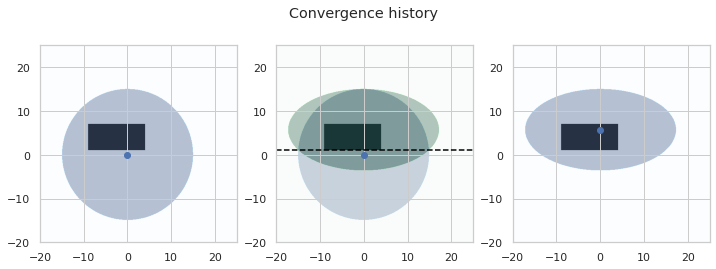

In [188]:
A = np.array([
    [0, -1],
    [-1, 0],
    [0, 1],
    [1, 0]
])

b = np.array([-1, 9, 7, 4])

z0 = np.array([0, 0]).reshape(-1, 1)
R0 = 15
D0 = np.array([
    [1, 0],
    [0, 1]
]) * ((R0)**2)

history = ellipsoid_method(A, b, z0, D0)
plot_history(A, b, history, bounds=[-20, 25])

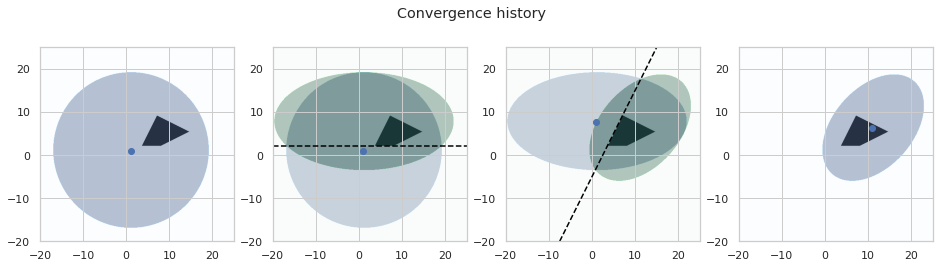

In [189]:
A = np.array([
    [0, -1],
    [1, 2],
    [2, -4],
    [-2, 1]
])

b = np.array([-2, 25, 8, -5])

z0 = np.array([1, 1]).reshape(-1, 1)
R0 = 18
D0 = np.array([
    [1, 0],
    [0, 1]
]) * ((R0)**2)

history = ellipsoid_method(A, b, z0, D0)
plot_history(A, b, history, bounds=[-20, 25])

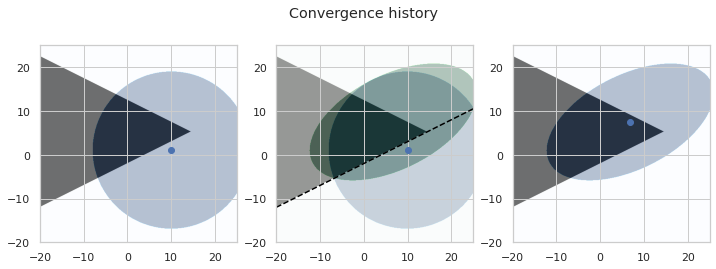

In [190]:
A = np.array([
    [1, 2],
    [2, -4]
])

b = np.array([25, 8])

z0 = np.array([10, 1]).reshape(-1, 1)
R0 = 18
D0 = np.array([
    [1, 0],
    [0, 1]
]) * ((R0)**2)

history = ellipsoid_method(A, b, z0, D0)
plot_history(A, b, history, bounds=[-20, 25])

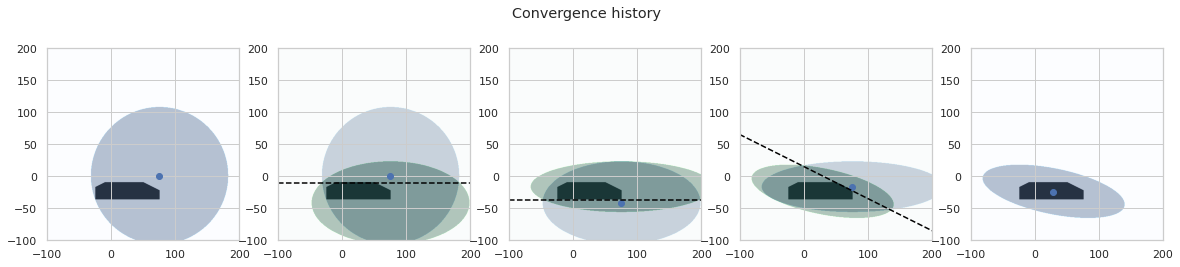

In [191]:
A = np.array([
    [-1, 2],
    [0, 1],
    [1, 2],
    [-1, 0],
    [1, 0],
    [0, -1],
])

b = np.array([-10, -10, 30, 25, 75, 37])

z0 = np.array([75, 0]).reshape(-1, 1)
R0 = 107
D0 = np.array([
    [1, 0],
    [0, 1]
]) * ((R0)**2)

history = ellipsoid_method(A, b, z0, D0)
plot_history(A, b, history, bounds=[-100, 200])
# plot_poly(A, b, [-50, 100])

In [192]:
A = np.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, -1, 0],
    [0, 0, 1],
    [0, 0, -1],
])

b = np.array([5, 5, 5, 5, 5, 5])

z0 = np.array([15, 15, 0]).reshape(-1, 1)
R0 = 100
D0 = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]) * ((R0)**2)

history = ellipsoid_method(A, b, z0, D0)
plot_history(A, b, history, bounds=[-100, 200])

Unable to plot data
Converged in 7 steps
z = [-4.375       2.69342189  0.        ]
